## Chapter 3.1 线性回归


In [16]:
import torch
from d2l import torch as d2l

%matplotlib inline
import math
import time
import numpy as np
import random




In [5]:
# 矢量化加速

n = 10000
a = torch.ones([n])
b = torch.ones([n])

In [6]:
# Define Timer

#@save

class Timer:
    def __init__(self):
        self.times = []
        self.start()
        
    def start(self):
        self.tik = time.time()
        
    def stop(self):
        self.times.append((time.time() - self.tik))
        return self.times[-1]
    
    def avg(self):
        return sum(self.times) / len(self.times)
    
    def sum(self):
        return sum(self.times)
    
    def cumsum(self):
        return np.array(self.times).cumsum().tolist()
    
    

In [10]:
# 先用for循环来执行加法

c = torch.zeros(n)

timer = Timer()

timer.start()

for i in range(n):
    c[i] = a[i] + b[i]
    
f'{timer.stop():.5f} sec'

'0.09490 sec'

In [11]:
timer.start()
d = a + b
f'{timer.stop():.5f} sec'

'0.00019 sec'

In [12]:
# 定义一个正态分布

def normal(x, mu, sigma):
    p = 1 / math.sqrt(2 * math.pi * sigma**2)
    return p * np.exp(-0.5 / sigma**2 * (x - mu)**2 )

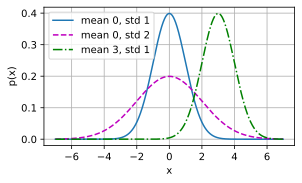

In [15]:
# 把定义的正态分布可视化

x = np.arange(-7, 7, 0.01)

# 均值与方差的参数
params = [(0, 1), (0, 2), (3, 1)]

d2l.plot(x, [normal(x, mu, sigma) for mu, sigma in params], 
         xlabel='x', ylabel='p(x)', 
         figsize=(4.5, 2.5), 
         legend=[f'mean {mu}, std {sigma}' for mu, sigma in params])

## Chapter 3.2 线性回归的从零开始实现


In [18]:
# 生成数据集

#@save

def synthetic_data(w, b, num_examples):
    """生成y=Xw +b + noise"""
    
    X = torch.normal(0, 1, (num_examples, len(w)))
    y = torch.matmul(X, w) + b
    y += torch.normal(0, 0.01, y.shape)
    
    return X, y.reshape((-1, 1))

true_w = torch.tensor([2, -3.4])
true_b = 4.2

features, labels = synthetic_data(true_w, true_b, 1000)

print('features:', features[0], '\nlabel:', labels[0])

features: tensor([-1.2449,  0.7643]) 
label: tensor([-0.8680])


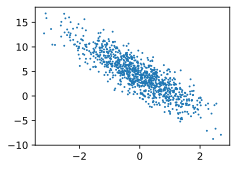

In [20]:
d2l.set_figsize()
d2l.plt.scatter(features[:, (1)].detach().numpy(), labels.detach().numpy(), 1)

In [21]:
# 读取小批量的数据

def data_iter(batch_size, features, labels):
    num_examples = len(features)
    indices = list(range(num_examples))
    
    random.shuffle(indices)
    
    for i in range(0, num_examples, batch_size):
        batch_indices = torch.tensor(indices[i: min(i + batch_size, num_examples)])
        yield features[batch_indices], labels[batch_indices]
        

In [22]:
batch_size = 10

for X, y in data_iter(batch_size, features, labels):
    print(X, '\n', y)
    break

tensor([[ 1.2646,  0.3660],
        [ 0.7760,  1.2140],
        [ 0.1541,  0.3158],
        [ 1.5701,  1.1679],
        [-1.1713, -0.2443],
        [-0.4392,  0.2224],
        [-0.1817,  1.3162],
        [ 0.9337,  0.5508],
        [-0.5945,  1.8483],
        [ 0.0467,  0.1624]]) 
 tensor([[ 5.4920],
        [ 1.6364],
        [ 3.4290],
        [ 3.3842],
        [ 2.6831],
        [ 2.5606],
        [-0.6524],
        [ 4.2004],
        [-3.2671],
        [ 3.7377]])


In [47]:
# 先初始化参数

w = torch.normal(0, 0.01, size=(2, 1), requires_grad=True)
b = torch.zeros(1, requires_grad=True)
w, b

(tensor([[0.0157],
         [0.0096]], requires_grad=True),
 tensor([0.], requires_grad=True))

In [25]:
# 定义线性回归模型

#@save

def linreg(X, w, b):
    """线性回归模型"""
    return torch.matmul(X, w) + b

In [28]:
# 定义均方损失函数

#@save

def squared_loss(y_hat, y):
    """均方损失"""
    return (y_hat - y.reshape(y_hat.shape)) ** 2 / 2


In [26]:
# 定义优化算法

#@save 

def sgd(params, lr, batch_size):
    """小批量随机梯度下降"""
    with torch.no_grad():
        for param in params:
            param -= lr * param.grad / batch_size
            param.grad.zero_()
            

* 在每次迭代中，我们读取一小批量训练样本，并通过我们的模型来获得一组预测。 计算完损失后，我们开始反向传播，存储每个参数的梯度。 最后，我们调用优化算法sgd来更新模型参数。

* 在每个迭代周期（epoch）中，我们使用data_iter函数遍历整个数据集， 并将训练数据集中所有样本都使用一次（假设样本数能够被批量大小整除）。 这里的迭代周期个数num_epochs和学习率lr都是超参数，分别设为3和0.03。 设置超参数很棘手，需要通过反复试验进行调整。

In [48]:
# 训练过程
# 如果要重新训练，先执行前面的wb参数初始化

lr = 0.01
num_epochs = 10
net = linreg
loss = squared_loss

for epoch in range(num_epochs):
    for X, y in data_iter(batch_size, features, labels):
        l = loss(net(X, w, b), y)
        l.sum().backward()
        sgd([w, b], lr, batch_size)
        
    with torch.no_grad():
        train_l = loss(net(features, w, b), labels)
        print(f'epoch {epoch + 1}, loss {float(train_l.mean()):f}')

epoch 1, loss 2.135193
epoch 2, loss 0.265541
epoch 3, loss 0.033082
epoch 4, loss 0.004171
epoch 5, loss 0.000564
epoch 6, loss 0.000113
epoch 7, loss 0.000056
epoch 8, loss 0.000049
epoch 9, loss 0.000048
epoch 10, loss 0.000048


In [49]:
# 评估误差

print(f'w的估计误差: {true_w - w.reshape(true_w.shape)}')
print(f'b的估计误差: {true_b - b}')

w的估计误差: tensor([-1.6451e-05,  5.4359e-05], grad_fn=<SubBackward0>)
b的估计误差: tensor([0.0002], grad_fn=<RsubBackward1>)


## Chapter 3.3 线性回归简洁实现


In [50]:
# 生成数据集

import numpy as np
import torch
from torch.utils import data
from d2l import torch as d2l

true_w = torch.tensor([2, -3.4])
true_b = 4.2

features, labels = d2l.synthetic_data(true_w, true_b, 1000)


In [51]:
# 读取数据集

#@save

def load_array(data_arrays, batch_size, is_train=True):
    """构造一个PyTorch数据迭代器"""
    dataset = data.TensorDataset(*data_arrays)
    return data.DataLoader(dataset, batch_size, shuffle=is_train)

batch_size = 10
data_iter = load_array((features, labels), batch_size)


In [52]:
# 验证数据加载是否成功
next(iter(data_iter))

[tensor([[-1.4607,  1.3300],
         [-0.7694,  0.2872],
         [-0.0474, -0.3963],
         [-0.2233,  1.6879],
         [ 0.6358,  0.6199],
         [-0.6503,  0.1832],
         [-0.0554,  0.8235],
         [ 1.2197, -0.7963],
         [ 0.3005,  0.7643],
         [-0.8316, -0.0890]]),
 tensor([[-3.2389],
         [ 1.6951],
         [ 5.4402],
         [-1.9947],
         [ 3.3719],
         [ 2.3091],
         [ 1.2916],
         [ 9.3619],
         [ 2.2035],
         [ 2.8376]])]

In [53]:
# 定义模型

# Sequential其实是一个pipeline

# nn是神经网络的缩写

from torch import nn

net = nn.Sequential(nn.Linear(2, 1))

In [61]:
# 初始化参数

net[0].weight.data.normal_(0, 0.01)
net[0].bias.data.fill_(0)


tensor([0.])

In [56]:
# 定义损失函数

loss = nn.MSELoss()


In [57]:
# 定义优化算法

trainer = torch.optim.SGD(net.parameters(), lr=0.03)

In [62]:
# 训练过程

num_epochs = 5
for epoch in range(num_epochs):
    for X, y in data_iter:
        l = loss(net(X), y)
        trainer.zero_grad()
        l.backward()
        trainer.step()
    
    l = loss(net(features), labels)
    print(f'epoch {epoch + 1}, loss {l:f}')
    

epoch 1, loss 0.000344
epoch 2, loss 0.000102
epoch 3, loss 0.000102
epoch 4, loss 0.000102
epoch 5, loss 0.000102


In [59]:
# 评估误差

w = net[0].weight.data
print('w的估计误差: ', true_w - w.reshape(true_w.shape))
b = net[0].bias.data
print('b的估计误差: ', true_b - b)

w的估计误差:  tensor([ 0.0006, -0.0008])
b的估计误差:  tensor([-0.0003])


## Chatper 3.4 softmax回归


* softmax运算获取一个向量并将其映射为概率。
* softmax回归适用于分类问题，它使用了softmax运算中输出类别的概率分布。
* 交叉熵是一个衡量两个概率分布之间差异的很好的度量，它测量给定模型编码数据所需的比特数。

## Chapter 3.5 图像分类数据集

In [65]:
%matplotlib inline
import torch
import torchvision
from torch.utils import data
from torchvision import transforms
from d2l import torch as d2l

d2l.use_svg_display()

* Fashion-MNIST由10个类别的图像组成，每个类别由训练数据集（train dataset）中的6000张图像 和测试数据集（test dataset）中的1000张图像组成。
* 因此，训练集和测试集分别包含60000和10000张图像。 测试数据集不会用于训练，只用于评估模型性能。
* 每个输入图像的高度和宽度均为28像素。 数据集由灰度图像组成，其通道数为1。 

In [67]:
# 读取Fashion-MNIST数据集

trans = transforms.ToTensor()
mnist_train = torchvision.datasets.FashionMNIST(root="~/SageMaker/data", train=True, transform=trans, download=True)
mnist_test = torchvision.datasets.FashionMNIST(root="~/SageMaker/data", train=False, transform=trans, download=True)


100%|██████████| 26421880/26421880 [00:02<00:00, 12555726.18it/s]


Extracting /home/ec2-user/SageMaker/data/FashionMNIST/raw/train-images-idx3-ubyte.gz to /home/ec2-user/SageMaker/data/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 210746.62it/s]


Extracting /home/ec2-user/SageMaker/data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to /home/ec2-user/SageMaker/data/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:01<00:00, 3865128.03it/s]


Extracting /home/ec2-user/SageMaker/data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to /home/ec2-user/SageMaker/data/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 18129535.68it/s]

Extracting /home/ec2-user/SageMaker/data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to /home/ec2-user/SageMaker/data/FashionMNIST/raw



In [68]:
len(mnist_train), len(mnist_test)

(60000, 10000)

In [70]:
mnist_train[0][0].shape, mnist_train[0][0]

(torch.Size([1, 28, 28]),
 tensor([[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0039, 0.0000, 0.0000, 0.0510,
           0.2863

* Fashion-MNIST中包含的10个类别，分别为t-shirt（T恤）、trouser（裤子）、pullover（套衫）、dress（连衣裙）、coat（外套）、sandal（凉鞋）、shirt（衬衫）、sneaker（运动鞋）、bag（包）和ankle boot（短靴）。

In [77]:
# 获取Fashion-MNIST数据集的文本标签
#@save

def get_fashion_mnist_labels(labels):
    """返回Fashion-MNIST数据集的文本标签"""
    text_labels = ['t-shirt', 'trouse', 'pullover', 'dress', 'coat', 'sandal', 'shirt', 'sneaker', 'bag', 'ankle boot']
    return [text_labels[int(i)] for i in labels]



In [80]:
# 可视化一些图像样本

#@save

def show_images(imgs, num_rows, num_cols, titles=None, scale=1.5):
    """绘制一些图像样本"""
    figsize = (num_cols * scale, num_rows * scale)
    _,axes = d2l.plt.subplots(num_rows, num_cols, figsize=figsize)
    axes = axes.flatten()
    for i, (ax, img) in enumerate(zip(axes, imgs)):
        if torch.is_tensor(img):
            ax.imshow(img.numpy())
        else:
            ax.imshow(img)
        ax.axes.get_xaxis().set_visible(False)
        ax.axes.get_yaxis().set_visible(False)
        if titles:
            ax.set_title(titles[i])
    return axes

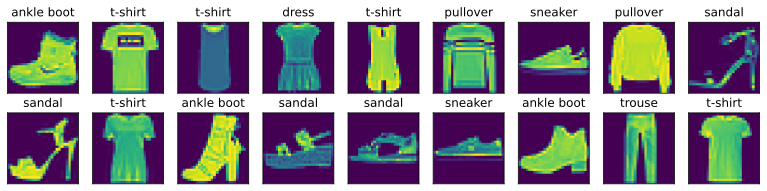

In [82]:
X, y = next(iter(data.DataLoader(mnist_train, batch_size=18)))
show_images(X.reshape(18, 28, 28), 2, 9, titles=get_fashion_mnist_labels(y));

In [87]:
batch_size = 256

#@save

def get_dataloader_workers():
    """使用4个进程来读取数据"""
    return 4

train_iter = data.DataLoader(mnist_train, batch_size, shuffle=True, num_workers=get_dataloader_workers())

timer = d2l.Timer()
for X, y in train_iter:
    continue

f'{timer.stop(): .2f} sec'

' 1.36 sec'

In [95]:
# 整合上面的图像数据读取相关组件

#@save

def load_data_fashion_mnist(batch_size, resize=None):
    trans = [transforms.ToTensor()]
    
    if resize:
        trans.insert(0, transforms.Resize(resize))
    
    trans = transforms.Compose(trans)
    
    mnist_train = torchvision.datasets.FashionMNIST(root="~/SageMaker/data", train=True, transform=trans, download=True)
    
    mnist_test = torchvision.datasets.FashionMNIST(root="~/SageMaker/data", train=False, transform=trans, download=True)
    
    return (data.DataLoader(mnist_train, batch_size, shuffle=True, num_workers=get_dataloader_workers()),
            data.DataLoader(mnist_test, batch_size, shuffle=False, num_workers=get_dataloader_workers()))


In [96]:
# 测试一下，利用resize参数

train_iter, test_iter = load_data_fashion_mnist(32, resize=64)

for X, y in train_iter:
    print(X.shape, X.dtype, y.shape, y.dtype)
    break
    


torch.Size([32, 1, 64, 64]) torch.float32 torch.Size([32]) torch.int64


## Chapter 3.6 softmax回归从零实现

In [97]:
import torch
from IPython import display
from d2l import torch as d2l

batch_size = 256
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size)


In [125]:
# 初始化模型参数

# 数据集FashionMNIST是28*28像素的图像，展平之后是784像素的向量，而输出的类别是10。
# 因此参数W是一个784 * 10的矩阵，b是一个长度为10向量。

num_inputs = 784
num_outputs = 10

W = torch.normal(0, 0.01, size=(num_inputs, num_outputs), requires_grad=True)
b = torch.zeros(num_outputs, requires_grad=True)


In [100]:
# 定义softmax操作

X = torch.tensor([[1.0, 2.0, 3.0], [4.0, 5.0, 6.0]])
X.sum(0, keepdim=True), X.sum(1, keepdim=True)

(tensor([[5., 7., 9.]]),
 tensor([[ 6.],
         [15.]]))

In [101]:
# 定义softmax函数

def softmax(X):
    X_exp = torch.exp(X)
    partition = X_exp.sum(1, keepdim=True)
    return X_exp / partition

In [102]:
X = torch.normal(0, 1, (2, 5))
X_prob = softmax(X)
X_prob, X_prob.sum(1)

(tensor([[0.2472, 0.4196, 0.1131, 0.1654, 0.0546],
         [0.5090, 0.0664, 0.0877, 0.2648, 0.0720]]),
 tensor([1.0000, 1.0000]))

In [103]:
# 定义模型

def net(X):
    return softmax(torch.matmul(X.reshape((-1, W.shape[0])), W) + b)


In [104]:
# 定义损失函数，交叉熵损失函数

def cross_entropy(y_hat, y):
    return - torch.log(y_hat[range(len(y_hat)), y])


In [107]:
# 测试一下交叉熵的计算

y = torch.tensor([0, 2])
y_hat = torch.tensor([[0.1, 0.3, 0.6], [0.3, 0.2, 0.5]])
y_hat[[0, 1], y]

cross_entropy(y_hat, y)

tensor([2.3026, 0.6931])

In [109]:
# 计算预测精度

#@save

def accuracy(y_hat, y):
    """计算预测正确的数量"""
    
    if len(y_hat.shape) > 1 and y_hat.shape[1] > 1:
        y_hat = y_hat.argmax(axis=1)
    cmp = y_hat.type(y.dtype) == y
    return float(cmp.type(y.dtype).sum())

accuracy(y_hat, y) / len(y)

0.5

In [110]:
# 在指定的数据集上评估模型的精度

#@save

def evaluate_accuracy(net, data_iter):
    """计算在指定数据集上模型的精度"""
    
    if isinstance(net, torch.nn.Module):
        net.eval() # 将模型设置为评估模式
    
    metric = Accumulator(2) # 正确预测数，预测总数
    with torch.no_grad():
        for X, y in data_iter:
            metric.add(accuracy(net(X), y), y.numel())
    
    return metric[0] / metric[1]

In [111]:
# 定义一个工具类Accumulator，用于对多个变量进行累加

#@save

class Accumulator:
    """在n个变量上累加"""
    def __init__(self, n):
        self.data = [0.0] * n
        
    def add(self, *args):
        self.data = [a + float(b) for a, b in zip(self.data, args)]
        
    def reset(self):
        self.data = [0.0] * len(self.data)
        
    def __getitem__(self, idx):
        return self.data[idx]
    

In [112]:
evaluate_accuracy(net, test_iter)

0.0776

In [148]:
# 训练过程

#@save

def train_epoch_ch3(net, train_iter, loss, updater):
    """训练模型一个迭代周期"""
    
    if isinstance(net, torch.nn.Module):
        net.train()
    
    # 训练损失总和，训练准确度总和，样本数
    metric = Accumulator(3)
    
    for X, y in train_iter:
        y_hat = net(X)
        l = loss(y_hat, y)
        
        if isinstance(updater, torch.optim.Optimizer):
            updater.zero_grad()
            l.mean().backward()
            updater.step()
        else:
            l.sum().backward()
            updater(X.shape[0])
        
        metric.add(float(l.sum()), accuracy(y_hat, y), y.numel())
    
    # 返回训练损失与训练精度
    return metric[0] / metric[2], metric[1] / metric[2]

In [122]:
# 定义一个在动画中绘制数据的工具类

#@save

class Animator:
    """在动画中绘制数据"""
    
    def __init__(self, xlabel=None, ylabel=None, legend=None, xlim=None, ylim=None, xscale='linear', yscale='linear',
                fmts=('-', 'm--', 'g-.', 'r:'), nrows=1, ncols=1, figsize=(3.5, 2.5)):
        
        # 增量地绘制多条线
        if legend is None:
            legend = []
        d2l.use_svg_display()
        self.fig, self.axes = d2l.plt.subplots(nrows, ncols, figsize=figsize)
        if nrows * ncols == 1:
            self.axes = [self.axes, ]
            
        # 使用Lambda函数捕获参数
        self.config_axes = lambda: d2l.set_axes(
            self.axes[0], xlabel, ylabel, xlim, ylim, xscale, yscale, legend)
        self.X, self.Y, self.fmts = None, None, fmts
        
    def add(self, x, y):
        # 向图表中增加多个绘制点
        
        if not hasattr(y, "__len__"):
            y = [y]
        
        n = len(y)
        
        if not hasattr(x, "__len__"):
            x = [x] * n
            
        if not self.X:
            self.X = [[] for _ in range(n)]
            
        if not self.Y:
            self.Y = [[] for _ in range(n)]
            
        for i, (a, b) in enumerate(zip(x, y)):
            if a is not None and b is not None:
                self.X[i].append(a)
                self.Y[i].append(b)
                
        self.axes[0].cla()
        
        for x, y, fmt in zip(self.X, self.Y, self.fmts):
            self.axes[0].plot(x, y, fmt)
        
        self.config_axes()
        
        display.display(self.fig)
        display.clear_output(wait=True)

In [138]:
# 整体训练过程

#@save

def train_ch3(net, train_iter, test_iter, loss, num_epochs, updater):
    """训练模型"""
    
    animator = Animator(xlabel='epoch', xlim=[1, num_epochs], ylim=[0.3, 0.9], 
                       legend=['train loss', 'train acc', 'test acc'])
    
    for epoch in range(num_epochs):
        train_metrics = train_epoch_ch3(net, train_iter, loss, updater)
        test_acc = evaluate_accuracy(net, test_iter)
        animator.add(epoch + 1, train_metrics + (test_acc,))
        
    train_loss, train_acc = train_metrics
    
    assert train_loss < 0.5, train_loss
    assert train_acc <=1 and train_acc > 0.7, train_acc
    

In [118]:
# 定义优化算法与学习率

lr = 0.1

def updater(batch_size):
    return d2l.sgd([W, b], lr, batch_size)

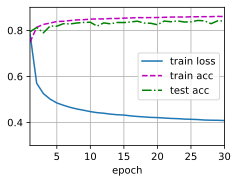

In [126]:
# 跑起来看看

num_epochs = 30

train_ch3(net, train_iter, test_iter, cross_entropy, num_epochs, updater)

In [129]:
# 预测一下

#@save

def predict_ch3(net, test_iter, n=6):
    """对图像进行分类"""
    
    for X, y in test_iter:
        break
    
    trues = d2l.get_fashion_mnist_labels(y)
    
    preds = d2l.get_fashion_mnist_labels(net(X).argmax(axis=1))
    
    titles = [true + '\n' + pred for true, pred in zip(trues, preds)]
    
    d2l.show_images(X[0:n].reshape((n, 28, 28)), 1, n, titles=titles[0:n])
    

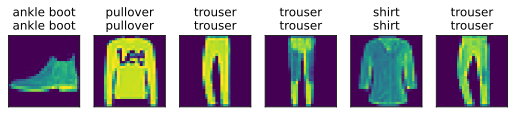

In [132]:
predict_ch3(net, test_iter)

## Chapter 3.7 softmax的简洁实现

In [140]:
# 加载数据

import torch
from torch import nn
from d2l import torch as d2l

batch_size = 256
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size)



In [141]:
# 初始化模型参数

net = nn.Sequential(nn.Flatten(), nn.Linear(784, 10))

def init_weights(m):
    if type(m) == nn.Linear:
        nn.init.normal_(m.weight, std=0.01)
        
net.apply(init_weights);


In [142]:
loss = nn.CrossEntropyLoss(reduction='none')

In [143]:
trainer = torch.optim.SGD(net.parameters(), lr=0.1)

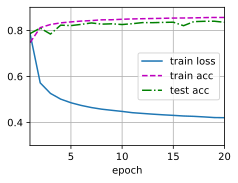

In [149]:
num_epochs = 20

# 这个例子有点问题，因为我安装的d2l中没有train_ch3的函数定义，因此跑不了，转而用前面定义的train_ch3函数，才能跑起来

#d2l.train_ch3(net, train_iter, test_iter, loss, num_epochs, trainer)
train_ch3(net, train_iter, test_iter, loss, num_epochs, trainer)

## 英文版 Chatper 4.5 Concise Implementation of Softmax Regression

In [150]:
import torch 
from torch import nn
from torch.nn import functional as F
from d2l import torch as d2l


In [151]:
# Define the model

class SoftmaxRegression(d2l.Classifier):
    """ The softmax regression model."""
    
    def __init__(self, num_outputs, lr):
        super().__init__()
        self.save_hyperparameters()
        self.net = nn.Sequential(nn.Flatten(),
                                nn.LazyLinear(num_outputs))
        
    def forward(self, X):
        return self.net(X)
    

In [154]:
@d2l.add_to_class(d2l.Classifier)

def loss(self, Y_hat, Y, averaged=True):
    Y_hat = Y_hat.reshape((-1, Y_hat.shape[-1]))
    Y = Y.reshape((-1,))
    
    return F.cross_entropy(
        Y_hat, Y, reduction='mean' if averaged else 'none')



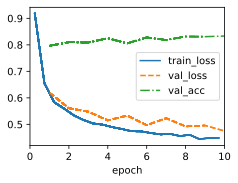

In [155]:
data = d2l.FashionMNIST(batch_size=256)
model = SoftmaxRegression(num_outputs=10, lr=0.1)
trainer = d2l.Trainer(max_epochs=10)
trainer.fit(model, data)